In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [5]:
RANDOM_SEED = 42

In [6]:
# 1) Load dataset
csv_path = r"c:\Users\koushik toni\Downloads\New folder\female_foeticide_risk.csv"
df = pd.read_csv(csv_path)
print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded data shape: (1000, 13)
Columns: ['district_name', 'state', 'literacy_rate_female', 'literacy_rate_male', 'sex_ratio', 'avg_household_income', 'poverty_index', 'education_expenditure_per_capita', 'female_infant_mortality_rate', 'access_to_health_facilities', 'employment_rate_female', 'social_awareness_programs', 'risk_level']


In [7]:
# 2) Quick inspection
print("\nSample rows:")
print(df.head(5))
print("\nTarget distribution:")
print(df['risk_level'].value_counts(dropna=False))



Sample rows:
  district_name      state  literacy_rate_female  literacy_rate_male  \
0     Darbhanga      Bihar                 66.73               75.26   
1     Bharatpur  Rajasthan                 81.35               77.90   
2         Patna      Bihar                 65.37               85.05   
3     Bhavnagar    Gujarat                 56.16               84.49   
4      Junagadh    Gujarat                 53.57               89.31   

   sex_ratio  avg_household_income  poverty_index  \
0      892.0               26906.0          0.524   
1      851.0               18326.0          0.352   
2      871.0               20108.0          0.332   
3      968.0               26189.0          0.397   
4      933.0               26398.0          0.906   

   education_expenditure_per_capita  female_infant_mortality_rate  \
0                            3769.2                          28.2   
1                            1203.2                          23.2   
2                          

In [8]:
# 3) Basic cleaning
# Trim string columns, consistent column names
df.columns = [c.strip() for c in df.columns]
str_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in str_cols:
    df[c] = df[c].astype(str).str.strip().replace({'nan':'', 'None':''})


In [9]:
# Replace empty strings with NaN for missing detection
df = df.replace({'': np.nan, 'NA': np.nan, 'nan': np.nan})


In [10]:
# Convert numeric columns to proper dtypes
num_cols = [
    'literacy_rate_female','literacy_rate_male','sex_ratio','avg_household_income',
    'poverty_index','education_expenditure_per_capita','female_infant_mortality_rate',
    'access_to_health_facilities','employment_rate_female','social_awareness_programs'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')


In [11]:
# Standardize target
df['risk_level'] = df['risk_level'].astype(str).str.strip().replace({'nan': np.nan})
print("\nMissing per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))



Missing per column:
literacy_rate_male                  21
district_name                       16
poverty_index                       13
employment_rate_female              11
state                               10
literacy_rate_female                10
education_expenditure_per_capita     9
social_awareness_programs            9
access_to_health_facilities          8
sex_ratio                            7
avg_household_income                 7
female_infant_mortality_rate         5
risk_level                           0
dtype: int64


In [12]:
# 4) Feature engineering (simple, interpretable)
# literacy gap
df['literacy_gap'] = df['literacy_rate_male'] - df['literacy_rate_female']
# income per poverty (interaction)
df['income_poverty'] = df['avg_household_income'] * (1 - df['poverty_index'])


In [13]:
# Fill district_name/state missing to avoid issues in encoding
df['district_name'] = df['district_name'].fillna('Unknown')
df['state'] = df['state'].fillna('Unknown')


In [14]:
# 5) Prepare X and y
target = 'risk_level'
df = df.dropna(subset=[target])  # drop rows where target missing
X = df.drop(columns=[target])
y = df[target].astype(str)


In [15]:
# Keep class labels consistent (Low, Medium, High)
y = y.replace({'low':'Low','Low':'Low','LOW':'Low',
               'medium':'Medium','Medium':'Medium','MEDIUM':'Medium',
               'high':'High','High':'High','HIGH':'High'})

print("\nFinal target counts:")
print(y.value_counts())



Final target counts:
Low       334
Medium    333
High      333
Name: risk_level, dtype: int64


In [16]:
# 6) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)
print("\nTrain / Test shapes:", X_train.shape, X_test.shape)



Train / Test shapes: (800, 14) (200, 14)


In [17]:
# 7) Preprocessing pipeline
numeric_features = [
    'literacy_rate_female','literacy_rate_male','literacy_gap','sex_ratio',
    'avg_household_income','poverty_index','education_expenditure_per_capita',
    'female_infant_mortality_rate','access_to_health_facilities',
    'employment_rate_female','social_awareness_programs','income_poverty'
]

In [18]:
# Keep categorical features: state (one-hot). district_name is high-cardinality -> encode as 'freq' or drop
categorical_features = ['state']
# District name: convert to frequency encoding to keep info but avoid too many columns
# Implement frequency encoding separately
for col in ['district_name']:
    freq = X_train[col].value_counts(normalize=True)
    X_train[f'{col}_freq'] = X_train[col].map(freq).fillna(0.0)
    X_test[f'{col}_freq'] = X_test[col].map(freq).fillna(0.0)
    numeric_features.append(f'{col}_freq')


In [19]:
# Build transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop', verbose_feature_names_out=False)


In [20]:
# 8) Baseline models in pipelines
def build_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

models = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, class_weight='balanced')
}


In [21]:
results = {}
for name, clf in models.items():
    pipe = build_pipeline(clf)
    print(f"\nTraining & CV for: {name}")
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"{name} CV macro-F1: {scores.mean():.4f} ± {scores.std():.4f}")
    results[name] = scores.mean()



Training & CV for: Dummy
Dummy CV macro-F1: 0.1659 ± 0.0000

Training & CV for: Logistic
Logistic CV macro-F1: 0.8883 ± 0.0171

Training & CV for: RandomForest
RandomForest CV macro-F1: 0.8495 ± 0.0139


In [22]:
# 10) Fit best baseline (RandomForest) and evaluate on test set
best_name = max(results, key=results.get)
print("\nBest baseline by CV macro-F1:", best_name)
best_pipe = build_pipeline(models[best_name])
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)



Best baseline by CV macro-F1: Logistic


In [23]:
print("\nTest set evaluation (baseline):")
print(classification_report(y_test, y_pred, digits=4))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_test, y_pred))



Test set evaluation (baseline):
              precision    recall  f1-score   support

        High     0.9118    0.9254    0.9185        67
         Low     0.9385    0.9104    0.9242        67
      Medium     0.8358    0.8485    0.8421        66

    accuracy                         0.8950       200
   macro avg     0.8953    0.8948    0.8950       200
weighted avg     0.8956    0.8950    0.8952       200

Macro F1: 0.8949554019729459
Accuracy: 0.895


In [24]:
# 11) Hyperparameter tuning (RandomizedSearchCV) for RandomForest and Logistic (example)
param_dist_rf = {
    'classifier__n_estimators': [100, 200, 400],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
rf_pipe = build_pipeline(RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'))

rs_rf = RandomizedSearchCV(
    rf_pipe, param_dist_rf, n_iter=12, scoring='f1_macro',
    cv=cv, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rs_rf.fit(X_train, y_train)
print("\nRandomForest best params:", rs_rf.best_params_)
print("RandomForest best CV f1_macro:", rs_rf.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits

RandomForest best params: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
RandomForest best CV f1_macro: 0.8557347923449117


In [25]:
# 12) LightGBM (optional, faster). If not installed, will skip
use_lgb = False
try:
    import lightgbm as lgb
    use_lgb = True
except Exception:
    use_lgb = False

if use_lgb:
    lgb_pipe = build_pipeline(lgb.LGBMClassifier(random_state=RANDOM_SEED, class_weight='balanced'))
    lgb_params = {
        'classifier__n_estimators': [100, 300],
        'classifier__max_depth': [-1, 10, 20],
        'classifier__learning_rate': [0.01, 0.05, 0.1]
    }
    rs_lgb = RandomizedSearchCV(lgb_pipe, lgb_params, n_iter=6, scoring='f1_macro', cv=cv, n_jobs=-1, random_state=RANDOM_SEED, verbose=1)
    rs_lgb.fit(X_train, y_train)
    print("\nLightGBM best CV f1_macro:", rs_lgb.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits

LightGBM best CV f1_macro: 0.8475528394951105


In [26]:
# 13) Evaluate tuned RF on test
best_rf = rs_rf.best_estimator_ if 'rs_rf' in locals() else rs_rf
y_pred_rf = rs_rf.predict(X_test)
print("\nTuned RandomForest test evaluation:")
print(classification_report(y_test, y_pred_rf, digits=4))
print("Macro F1:", f1_score(y_test, y_pred_rf, average='macro'))



Tuned RandomForest test evaluation:
              precision    recall  f1-score   support

        High     0.8906    0.8507    0.8702        67
         Low     0.9394    0.9254    0.9323        67
      Medium     0.7857    0.8333    0.8088        66

    accuracy                         0.8700       200
   macro avg     0.8719    0.8698    0.8705       200
weighted avg     0.8723    0.8700    0.8708       200

Macro F1: 0.8704611213710072


In [27]:
# 14) Feature importance (from RandomForest)
# We need to get feature names from preprocessor
feature_names_num = numeric_features
# get onehot categories
ohe = rs_rf.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
ohe_cols = []
try:
    ohe_cols = list(ohe.get_feature_names_out(categorical_features))
except Exception:
    ohe_cols = []
feature_names = feature_names_num + ohe_cols

rf_model = rs_rf.best_estimator_.named_steps['classifier']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
print("\nTop feature importances (RandomForest):")
print(feat_imp)



Top feature importances (RandomForest):
poverty_index                       0.349068
income_poverty                      0.237636
literacy_rate_female                0.059478
literacy_gap                        0.047118
avg_household_income                0.042630
sex_ratio                           0.036311
literacy_rate_male                  0.032347
employment_rate_female              0.032173
access_to_health_facilities         0.030710
female_infant_mortality_rate        0.028885
education_expenditure_per_capita    0.027113
social_awareness_programs           0.025445
district_name_freq                  0.017869
state_Maharashtra                   0.003983
state_Odisha                        0.003740
state_Gujarat                       0.003716
state_Haryana                       0.003703
state_Madhya Pradesh                0.003439
state_Rajasthan                     0.003156
state_West Bengal                   0.003099
state_Punjab                        0.002902
state_Uttar Pr

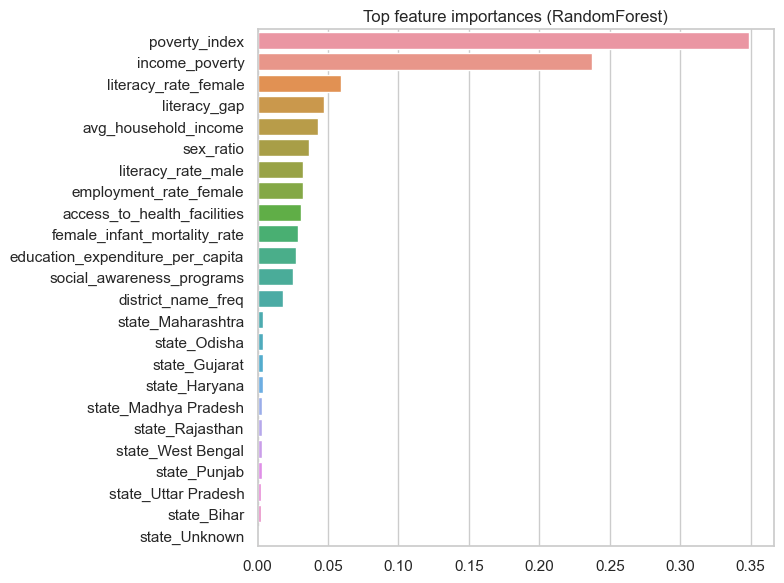

In [28]:
# Plot top features
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top feature importances (RandomForest)")
plt.tight_layout()
plt.savefig("feature_importances_rf.png", dpi=150)


In [29]:
# 15) Save final model and test predictions
out_model_path = os.path.join(os.getcwd(), "final_model_rf.joblib")
joblib.dump(rs_rf.best_estimator_, out_model_path)
print("\nSaved tuned RandomForest pipeline to:", out_model_path)

pred_df = X_test.copy()
pred_df['true_risk'] = y_test
pred_df['predicted_risk'] = y_pred_rf
pred_df.to_csv("test_predictions.csv", index=False)
print("Saved test predictions to test_predictions.csv")



Saved tuned RandomForest pipeline to: C:\Users\koushik toni\final_model_rf.joblib
Saved test predictions to test_predictions.csv


In [31]:
pwd

'C:\\Users\\koushik toni'